In [1]:
#Loading all the packages which will be used along the exam

import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import geopandas as gpd
from geopandas.geoseries import *
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import ast
import json
import urllib
import urllib2
import mplleaflet
from cStringIO import StringIO
from scipy.cluster.vq import whiten

Populating the interactive namespace from numpy and matplotlib


#Task 1: Querying Asthma Discharges

In [2]:
#Defining queryCartoDB function

SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
#Using SQL query to find the top 5 facilities in terms of asthma cases

asthmaQuery = '''
SELECT facility_id, count(*) 
FROM nyc_discharge_2013
WHERE ccs_diagnosis_description
LIKE '%ASTHMA%'
GROUP BY facility_id
ORDER BY count DESC
LIMIT 5
'''

asthmaStream = queryCartoDB(asthmaQuery, format='CSV')
asthma5 = pd.read_csv(asthmaStream)
asthma5

,facility_id,count
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


In [4]:
#Loading information on all facilities with SQL

facilityQuery = '''
SELECT *
FROM nyc_facilities

'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])
facilities.keys()

Index([                  u'cartodb_id',           u'cooperator_address',
               u'cooperator_address_2',              u'cooperator_city',
                    u'cooperator_name',             u'cooperator_state',
                u'cooperator_zip_code',                  u'description',
                 u'facility_address_1',           u'facility_address_2',
                      u'facility_city',              u'facility_county',
               u'facility_county_code',          u'facility_fax_number',
                        u'facility_id',            u'facility_latitude',
                  u'facility_location',           u'facility_longitude',
                      u'facility_name',           u'facility_open_date',
              u'facility_phone_number',               u'facility_state',
                   u'facility_website',            u'facility_zip_code',
                           u'geometry',        u'main_site_facility_id',
                     u'main_site_name', u'operating

#1.1. The list the top 5 facilities by their facility names (aka. the **facility_name** column)

In [5]:
#Generating table for top5 facilities with names and geo-reference information

facilities5 = pd.merge(asthma5, facilities, on=['facility_id'])
facilities5 = facilities5[['facility_name', 'facility_id', 'count', 'facility_latitude', 'facility_longitude', ]]

#Converting points to EPSG:2263

facilities5['points'] = [Point(facilities5.facility_longitude[i], facilities5.facility_latitude[i]) \
                         for i in facilities5.index]
facilities5_loc = gpd.GeoSeries(facilities5['points'])
facilities5_loc.crs = {'init': 'epsg:4326', 'no_defs': True}
facilities5_loc.to_crs(epsg=2263)
facilities5['points'] = facilities5_loc
facilities5

,facility_name,facility_id,count,facility_latitude,facility_longitude,points
0,Lincoln Medical & Mental Health Center,1172,1878,40.817661,-73.924210,POINT (-73.92421 40.817661)
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,40.879951,-73.880562,POINT (-73.880562 40.879951)
2,Kings County Hospital Center,1301,1057,40.655823,-73.944099,POINT (-73.94409899999999 40.655823)
3,Jacobi Medical Center,1165,920,40.857388,-73.846741,POINT (-73.84674099999999 40.857388)
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,40.843609,-73.911545,POINT (-73.911545 40.843609)


In [6]:
print list(facilities5['facility_name'])

[u'Lincoln Medical & Mental Health Center', u'Montefiore Medical Center - Henry & Lucy Moses Div', u'Kings County Hospital Center', u'Jacobi Medical Center', u'Bronx-Lebanon Hospital Center - Concourse Division']


#1.2 A map of those 5 facilities in the NAD 83 / New York Long Island (EPSG:2263) coordiantes.

In [7]:
#Plotting the map

pl.figure(figsize=(10, 8))
for i in range(len(facilities5_loc)):
    pl.plot(facilities5_loc[i].x, facilities5_loc[i].y, 'o', color = 'firebrick', markersize = 10)
xlim(-74.2700, -74.2700)
ylim(40.4700,41.3100)
mplleaflet.display()

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-74.27, right=-74.27
  'left=%s, right=%s') % (left, right))


#Task 2: Geo-referencing the facilities with the zip code highway profile

In [8]:
#Loading highway length info per ZIP code

zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData = json.loads(zipcodeStream.read())
zipcodes = gpd.GeoDataFrame.from_features(zipcodeData['features'])
zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172


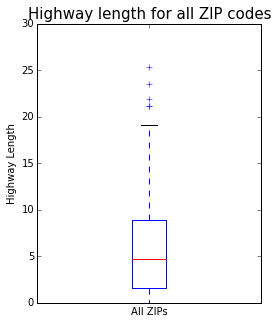

In [9]:
#Boxplotting the highway length for all ZIP codes to have check its range

pl.figure(figsize=(4,5))
pl.boxplot(zipcodes.highway_length)
pl.xticks([1], ['All ZIPs'])

pl.ylabel("Highway Length", fontsize=10)
pl.title("Highway length for all ZIP codes", fontsize=15)

In [10]:
#Using Geopandas to find the ZIP code for each facility
#I realize they are in the facilities database as well, but assume we're supposed to do it the "harder" way...

facilities5['zipcode'] = np.zeros(len(facilities5))

for p in range(len(facilities5['points'])):   

    for z in range(len(zipcodes)):
        if facilities5['points'][p].intersects(zipcodes['geometry'][z]) == True:
            facilities5['zipcode'][p] = zipcodes['zipcode'][z]
            
facilities5

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,facility_name,facility_id,count,facility_latitude,facility_longitude,points,zipcode
0,Lincoln Medical & Mental Health Center,1172,1878,40.817661,-73.924210,POINT (-73.92421 40.817661),10451
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,40.879951,-73.880562,POINT (-73.880562 40.879951),10467
2,Kings County Hospital Center,1301,1057,40.655823,-73.944099,POINT (-73.94409899999999 40.655823),11203
3,Jacobi Medical Center,1165,920,40.857388,-73.846741,POINT (-73.84674099999999 40.857388),10461
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,40.843609,-73.911545,POINT (-73.911545 40.843609),10457


#2.1. a list of 5 facilities (like in Task 1.1) but with two additional columns: the ZIP code and the total highway miles belonging to that zip code.

In [11]:
#Finding the total highway miles belonging to that zip code

facilities5 = facilities5.drop(['points', 'facility_latitude', 'facility_longitude'], 1)
facilities5 = pd.merge(facilities5, zipcodes[['zipcode', 'highway_length']], on = ['zipcode'])
facilities5

,facility_name,facility_id,count,zipcode,highway_length
0,Lincoln Medical & Mental Health Center,1172,1878,10451,7.914185
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,10467,19.172015
2,Kings County Hospital Center,1301,1057,11203,2.212840
3,Jacobi Medical Center,1165,920,10461,18.102258
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,10457,5.017199


#2.2. a map (cloropleth) of highway length for all NYC ZIP codes.

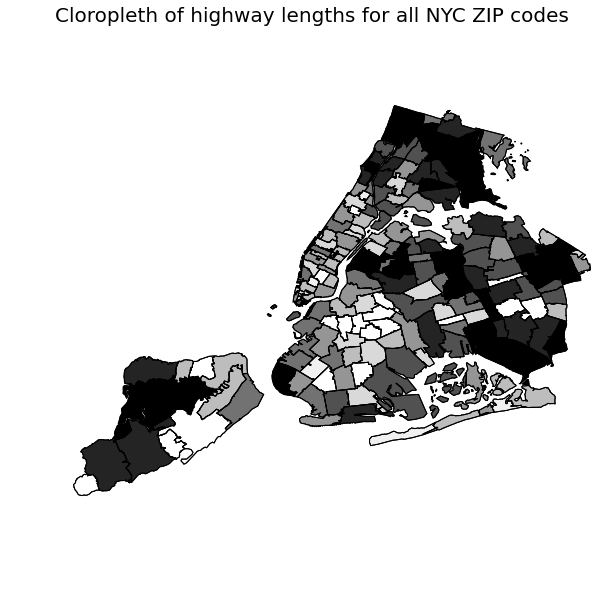

In [12]:
#Plotting cloropleth

pl.figure(figsize=(10, 10))
zipcodes.plot(column='highway_length', scheme='QUANTILES', k=9, alpha=1, colormap='Greys')
pl.axis('off')
pl.title("Cloropleth of highway lengths for all NYC ZIP codes", fontsize=20)

#TASK 3 : Murder rate

In [13]:
#Loading data from NYPD

crime_data = pd.read_excel('http://www.nyc.gov/html/nypd/downloads/excel/analysis_and_planning/seven_major_felony_offenses_by_precinct_2000_2014.xls', header = 2)
crime_data.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3,1,2,2,2,0,1,0,1,2,2,0,1,0,0
1,NaN,RAPE,12,5,10,11,11,5,4,7,12,4,6,13,10,12,8
2,NaN,ROBBERY,252,188,210,164,154,172,119,128,108,106,96,102,81,68,50
3,NaN,FELONY ASSAULT,139,164,147,134,129,121,94,90,83,83,68,94,110,87,76
4,NaN,BURGLARY,475,437,297,403,246,293,255,231,189,207,170,155,188,171,145


In [14]:
#Restricting data to murders

crime_data = crime_data[crime_data['CRIME'] == 'MURDER & NON NEGL. MANSLAUGHTER                                ']
crime_data.index = range(len(crime_data))
crime_data.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3,1,2,2,2,0,1,0,1,2,2,0,1,0,0
1,5,MURDER & NON NEGL. MANSLAUGHTER ...,4,3,0,3,1,4,2,2,2,1,1,0,3,3,2
2,6,MURDER & NON NEGL. MANSLAUGHTER ...,0,1,0,1,3,1,3,5,0,1,1,1,1,2,2
3,7,MURDER & NON NEGL. MANSLAUGHTER ...,0,3,5,6,3,7,4,2,3,2,1,5,0,1,0
4,9,MURDER & NON NEGL. MANSLAUGHTER ...,3,2,1,3,4,2,1,0,3,4,4,1,1,2,2


In [15]:
#Calculating the 3-year average for the 2011-2013 period

crime_data['3y avg'] = (crime_data['2011'] + crime_data[2012] + crime_data[2013])/3
crime_data.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,3y avg
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3,1,2,2,2,0,1,0,1,2,2,0,1,0,0,0.333333
1,5,MURDER & NON NEGL. MANSLAUGHTER ...,4,3,0,3,1,4,2,2,2,1,1,0,3,3,2,2.000000
2,6,MURDER & NON NEGL. MANSLAUGHTER ...,0,1,0,1,3,1,3,5,0,1,1,1,1,2,2,1.333333
3,7,MURDER & NON NEGL. MANSLAUGHTER ...,0,3,5,6,3,7,4,2,3,2,1,5,0,1,0,2.000000
4,9,MURDER & NON NEGL. MANSLAUGHTER ...,3,2,1,3,4,2,1,0,3,4,4,1,1,2,2,1.333333


In [16]:
#Loading precincts data and checking crs
#Available at https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz

precincts = gpd.GeoDataFrame.from_file('nypp_15d/nypp.shp')
precincts.crs

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.



{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

In [17]:
#Converting GeoSeries crs to WGS (the zipcodes file has no embedded crs argument, but I assume it is in WGS)

precincts = precincts.to_crs(epsg=4326)
precincts.head()

,Precinct,Shape_Area,Shape_Leng,geometry
0,1,47182160.4145,79979.409545,(POLYGON ((-74.04387761573955 40.6901876764099...
1,5,18088797.9526,18676.124259,POLYGON ((-73.98863862848768 40.72293372029702...
2,6,22131930.5198,27182.610113,POLYGON ((-73.99968392160723 40.73855224869308...
3,7,18363326.3567,17301.492549,POLYGON ((-73.97345324119571 40.71896288711555...
4,9,21394013.3755,19773.401872,POLYGON ((-73.97160900246391 40.72672340120321...


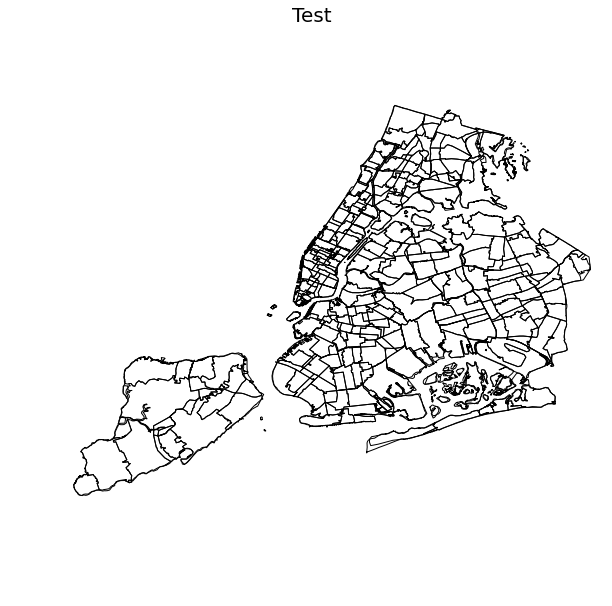

In [18]:
#Just checking if ZIP codes and precincts are in the same crs now: they are

pl.figure(figsize=(10,10))
zipcodes.plot(alpha=0)
precincts.plot(alpha=0)
pl.axis('off')
pl.title("Test", fontsize=20)

In [19]:
#Calculating centroids for precincts

precincts = precincts.rename(columns = {'Precinct':'PCT'})
precincts['centroid'] = gpd.GeoSeries(precincts['geometry'].centroid)
precincts.head()

,PCT,Shape_Area,Shape_Leng,geometry,centroid
0,1,47182160.4145,79979.409545,(POLYGON ((-74.04387761573955 40.6901876764099...,POINT (-74.01205356726895 40.70974421326174)
1,5,18088797.9526,18676.124259,POLYGON ((-73.98863862848768 40.72293372029702...,POINT (-73.9971459534532 40.71641498829828)
2,6,22131930.5198,27182.610113,POLYGON ((-73.99968392160723 40.73855224869308...,POINT (-74.00238131687975 40.7336618976345)
3,7,18363326.3567,17301.492549,POLYGON ((-73.97345324119571 40.71896288711555...,POINT (-73.9839459898609 40.71543854171556)
4,9,21394013.3755,19773.401872,POLYGON ((-73.97160900246391 40.72672340120321...,POINT (-73.98338742578144 40.72626543524132)


In [20]:
#Including precinct info in crime database

crime_data = pd.merge(crime_data, precincts, on = ['PCT'])
crime_data

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,3y avg,Shape_Area,Shape_Leng,geometry,centroid
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3,1,2,2,2,0,1,0,...,2,0,1,0,0,0.333333,4.718216e+07,79979.409545,(POLYGON ((-74.04387761573955 40.6901876764099...,POINT (-74.01205356726895 40.70974421326174)
1,5,MURDER & NON NEGL. MANSLAUGHTER ...,4,3,0,3,1,4,2,2,...,1,0,3,3,2,2.000000,1.808880e+07,18676.124259,POLYGON ((-73.98863862848768 40.72293372029702...,POINT (-73.9971459534532 40.71641498829828)
2,6,MURDER & NON NEGL. MANSLAUGHTER ...,0,1,0,1,3,1,3,5,...,1,1,1,2,2,1.333333,2.213193e+07,27182.610113,POLYGON ((-73.99968392160723 40.73855224869308...,POINT (-74.00238131687975 40.7336618976345)
3,7,MURDER & NON NEGL. MANSLAUGHTER ...,0,3,5,6,3,7,4,2,...,1,5,0,1,0,2.000000,1.836333e+07,17301.492549,POLYGON ((-73.97345324119571 40.71896288711555...,POINT (-73.9839459898609 40.71543854171556)
4,9,MURDER & NON NEGL. MANSLAUGHTER ...,3,2,1,3,4,2,1,0,...,4,1,1,2,2,1.333333,2.139401e+07,19773.401872,POLYGON ((-73.97160900246391 40.72672340120321...,POINT (-73.98338742578144 40.72626543524132)
5,10,MURDER & NON NEGL. MANSLAUGHTER ...,2,3,2,2,5,4,4,0,...,2,3,3,1,0,2.333333,2.722863e+07,40043.175251,POLYGON ((-74.00138603698602 40.76285009503521...,POINT (-74.00168798412699 40.75053874303917)
6,13,MURDER & NON NEGL. MANSLAUGHTER ...,2,2,2,4,3,3,2,3,...,3,2,1,1,0,1.333333,2.950966e+07,27735.246247,"POLYGON ((-73.98155997085217 40.7438818833804,...",POINT (-73.98443891592935 40.73804004132369)
7,14,MURDER & NON NEGL. MANSLAUGHTER ...,7,4,8,4,2,1,1,2,...,0,2,1,2,0,1.666667,2.051016e+07,20974.709243,POLYGON ((-73.97464798076284 40.75336712266116...,POINT (-73.98713822390584 40.75203430851331)
8,17,MURDER & NON NEGL. MANSLAUGHTER ...,1,0,1,1,0,0,2,1,...,0,0,2,0,0,0.666667,2.227428e+07,26848.186307,(POLYGON ((-73.96421230395676 40.7466043185099...,POINT (-73.97112553265025 40.75127577119776)
9,18,MURDER & NON NEGL. MANSLAUGHTER ...,1,5,2,4,3,3,4,1,...,3,0,4,0,2,1.333333,3.228033e+07,42179.905777,POLYGON ((-73.99393666655918 40.77317984586927...,POINT (-73.98500434101092 40.76329703128419)


In [21]:
#Adding centroids to ZIP codes

zipcodes['centroid'] = gpd.GeoSeries(zipcodes['geometry'].centroid)
zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode,centroid
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,POINT (-74.16283492076543 40.5976266699402)
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,POINT (-73.97966815075586 40.75916748463532)
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,POINT (-74.01241667413252 40.71166480880465)
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,POINT (-73.97385832649107 40.75589934710471)
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,POINT (-73.97431480095811 40.75527331794677)


In [22]:
#Calculating distances of each zipcode to all precincts and checking them for my ZIP code

distances = {}
for z in zipcodes.zipcode:
    distances[z] = np.zeros(len(crime_data))
    
for z in range(len(zipcodes)):
    
    for p in range(len(crime_data)):
        distances[zipcodes['zipcode'][z]][p] = zipcodes['centroid'][z].distance(crime_data['centroid'][p])

distances[11216]

array([ 0.06922592,  0.05973897,  0.07498569,  0.04906371,  0.05687519,
        0.08727427,  0.0672008 ,  0.0806856 ,  0.07377255,  0.08990431,
        0.09222818,  0.10377427,  0.10293816,  0.11043357,  0.11665095,
        0.1173013 ,  0.13149268,  0.12378443,  0.1452258 ,  0.13867984,
        0.16046164,  0.18256092,  0.13409493,  0.14610544,  0.15988691,
        0.16846647,  0.15555383,  0.21386216,  0.1763891 ,  0.22769346,
        0.17987094,  0.19953202,  0.21712323,  0.19585333,  0.10549376,
        0.08660253,  0.08603018,  0.08299428,  0.0602262 ,  0.03620664,
        0.09402102,  0.07347936,  0.05000967,  0.0181898 ,  0.0594743 ,
        0.0402535 ,  0.07361064,  0.05409632,  0.0080391 ,  0.03005806,
        0.0083882 ,  0.02040038,  0.03508878,  0.04213807,  0.02432545,
        0.02794465,  0.04424125,  0.13565795,  0.20252667,  0.1086486 ,
        0.16469515,  0.06581852,  0.21316902,  0.11698012,  0.15838682,
        0.06510618,  0.16147974,  0.109218  ,  0.20452644,  0.10

In [23]:
#Checking if my dictionary can find the 5 closest precincts to my ZIP code
#It is correct, as checked here: http://www.nyc.gov/html/nypd/html/precinct_maps/precinct_finder.shtml
#The NYPD map also shows that each precinct is surrounded by around 5 precincts -> using that in my index 

print 'The 5 closes precincts to my zip code (11216) are: %s' % \
list(crime_data['PCT'][np.argsort(distances[11216])[:5]])

The 5 closes precincts to my zip code (11216) are: [77, 79, 71, 81, 88]


In [24]:
#Calculating the murder index
#Methodology: Sum of murders (2012-14 avg) in the 5 closest precincts devided by the distance between the centroid
#of the ZIP code and the centroid of the precinct

murder_index = {}

for z in zipcodes.zipcode:
    murders5 = crime_data['3y avg'][np.argsort(distances[z])[:5]]
    distances5 = np.sort(distances[z])[:5]
    weighted5 = murders5/distances5
    murder_index[z] = weighted5.sum()

In [25]:
#Comparing how violent my ZIP code is vs. the median of NYC (scary)
#Also checking how the maximum index compares to the median 

print 'The murder index in my ZIP code divided by the NYC median is: %s' % \
str(murder_index[11216]/median(murder_index.values()))

print 'The maximum index value divided by the NYC median is: %s' % \
str(murder_index[max(murder_index, key=murder_index.get)]/median(murder_index.values()))

The murder index in my ZIP code divided by the NYC median is: 4.65519396135
The maximum index value divided by the NYC median is: 15.1281677935


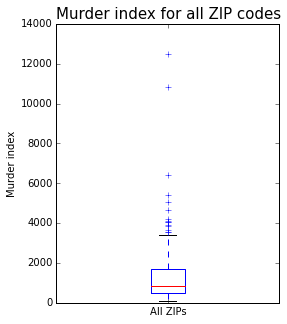

In [26]:
#Boxplotting the crime index for all ZIP codes to have check its range

pl.figure(figsize=(4,5))
pl.boxplot(murder_index.values())
pl.xticks([1], ['All ZIPs'])

pl.ylabel("Murder index", fontsize=10)
pl.title("Murder index for all ZIP codes", fontsize=15)

# 3.1. a dataframe like the one derived in TASK 2 but with an additional column: the exposure to violent crimes in the ZIP code of the 5 identified facilities.

In [27]:
#Including the murder_index column

facilities5['murder_index'] = facilities5['zipcode'].map(murder_index)

facilities5

,facility_name,facility_id,count,zipcode,highway_length,murder_index
0,Lincoln Medical & Mental Health Center,1172,1878,10451,7.914185,2991.181228
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,10467,19.172015,1715.579510
2,Kings County Hospital Center,1301,1057,11203,2.212840,12501.765158
3,Jacobi Medical Center,1165,920,10461,18.102258,1505.452743
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,10457,5.017199,3389.742120


#3.2. choropleth of the murder rate for all ZIP codes in NYC

In [28]:
#Including murder_index column in zipcodes

zipcodes['murder_index'] = zipcodes['zipcode'].map(murder_index)

zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode,centroid,murder_index
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,POINT (-74.16283492076543 40.5976266699402),163.272037
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,POINT (-73.97966815075586 40.75916748463532),543.451159
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,POINT (-74.01241667413252 40.71166480880465),477.997234
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,POINT (-73.97385832649107 40.75589934710471),449.850899
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,POINT (-73.97431480095811 40.75527331794677),462.897884


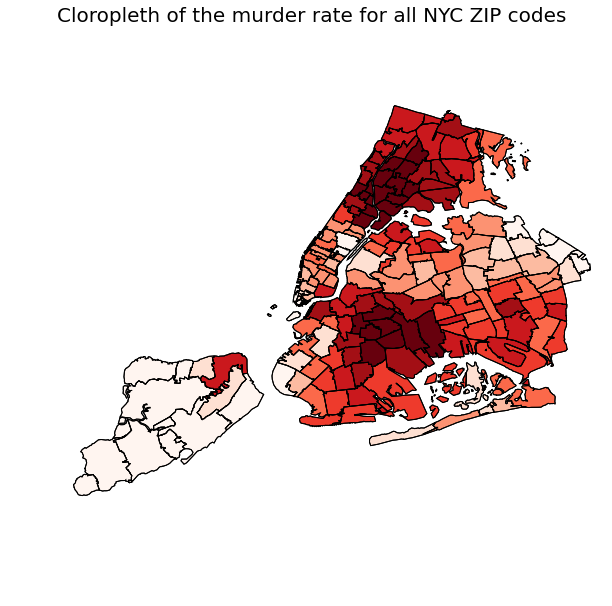

In [29]:
#Plotting cloropleth

pl.figure(figsize=(10, 10))
zipcodes.plot(column='murder_index', scheme='QUANTILES', k=9, alpha=1, colormap='Reds')
pl.axis('off')
pl.title("Cloropleth of the murder rate for all NYC ZIP codes", fontsize=20)

#TASK 4: Green space

In [30]:
#Loading parks data and adjusting its crs

parks = gpd.GeoDataFrame.from_file('New_York_City_Open_Spaces_-_Parks/PARK.shp')
parks = parks.to_crs(epsg=4326)
print len(parks)
parks.head()

12723


,FEATURE_CO,LANDUSE,PARKNUM,PARK_NAME,SHAPE_AREA,SHAPE_LEN,SOURCE_ID,STATUS,STATU_DESC,SUB_FEATUR,SYSTEM,geometry
0,4980,Jointly Operated Playground,Q353,Grassmere Playground,63116.358340,1346.004418,1498000230,Unchanged,No change in 2011 collection,498000,None,POLYGON ((-73.75870541639394 40.59879385803105...
1,4980,Cemetery,Q463,Cornell Burial Ground,19810.665550,602.456065,1498000231,Unchanged,No change in 2011 collection,498000,None,POLYGON ((-73.74957028964624 40.60023985828553...
2,4980,Community Park,Q007,Bayswater Park,1122375.346280,7501.947693,1498000232,Updated,Feature has changed in 2011 collection,498000,None,POLYGON ((-73.76822946704048 40.60110889177423...
3,4985,None,QZ167,Greenstreet,1051.555652,149.086008,1498000234,Updated,Feature has changed in 2011 collection,498500,QZ167,POLYGON ((-73.75942421968476 40.60228424171265...
4,4980,Nature Area,Q459,Dubos Point Wildlife Sanctuary,1324871.158250,6662.385446,1498000235,Updated,Feature has changed in 2011 collection,498000,None,POLYGON ((-73.78688604868985 40.60320875194793...


In [31]:
#Checking the types of parks

set(parks.LANDUSE)

{None,
 u'Buildings/Institutions',
 u'Cemetery',
 u'Community Park',
 u'EventArea',
 u'Flagship Park',
 u'Garden',
 u'Historic House Park',
 u'Jointly Operated Playground',
 u'LARGE PARK AREA',
 u'Lot',
 u'Mall',
 u'Nature Area',
 u'Neighborhood Park',
 u'Parkway',
 u'Pending Acquisitions',
 u'Playground',
 u'Recreation Field/Courts',
 u'Retired N/A',
 u'School Yard to Playground',
 u'Strip',
 u'Tracking Only',
 u'Triangle/Plaza',
 u'Undeveloped',
 u'Waterfront Facility',
 u'privately owned public space'}

In [32]:
#Cleaning unwanted categories

parks = parks[~(parks['LANDUSE'].isin([None, 'Buildings/Institutions', 'Lot', 'Mall', 'Strip']))]
len(parks)

4585

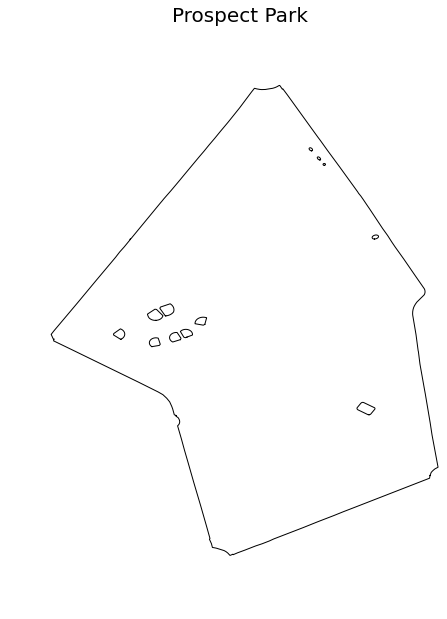

In [33]:
#After checking the whole dataset, I realized the shapefile is composed of different sections of each park
#I'll visualize Prospect Park to have a better sense of it

pl.figure(figsize=(10, 10))
parks[parks.PARK_NAME == 'Prospect Park'].plot(alpha=0)
pl.axis('off')
pl.title("Prospect Park", fontsize=20)

I also did the same for other parks, and it becomes clear that we should use the largest shape for each park (the smaller shapes are mostly constructions within the park).

In [34]:
#Creating dictionary with the area and geometry for the largest SHAPE_AREA of each park
#Testing the area for Prospect Park (I verified it is accurate)

parks_area = {}
parks_geometry = {}

for i in set(parks.PARK_NAME):
    parks_area[i] = parks['SHAPE_AREA'][parks['PARK_NAME'] == i].max()
    parks_geometry[i] = parks['geometry'][parks['PARK_NAME'] == i].max()

print parks_area['Prospect Park']

20705471.0829


In [35]:
#Creating GeoDataFrame with the data I'll need later

parks_max = gpd.GeoDataFrame(index=range(len(set(parks['PARK_NAME']))))

parks_max['PARK_NAME'] = set(parks['PARK_NAME'])
parks_max['SHAPE_AREA'] = parks_max['PARK_NAME'].map(parks_area)
parks_max['geometry'] = parks_max['PARK_NAME'].map(parks_geometry)
    
parks_max.head()

,PARK_NAME,SHAPE_AREA,geometry
0,Community Garden Association,1042.088533,"POLYGON ((-73.97894894375828 40.7283473137954,..."
1,Each One Teach One,2383.023144,POLYGON ((-73.93521543112155 40.80688121733752...
2,Manhattan Ave Street End,10165.679665,POLYGON ((-73.95494331977184 40.73905580434056...
3,Highland Park Childrens Garden,19656.663496,POLYGON ((-73.88804511051626 40.68271437362841...
4,Collyer Brothers Park,1479.516585,POLYGON ((-73.94091743876849 40.80851346836551...


In [36]:
#Calculating centroids for parks

parks_max['centroid'] = gpd.GeoSeries(parks_max['geometry'].centroid)
parks_max.head()

,PARK_NAME,SHAPE_AREA,geometry,centroid
0,Community Garden Association,1042.088533,"POLYGON ((-73.97894894375828 40.7283473137954,...",POINT (-73.97905956977336 40.72836654385404)
1,Each One Teach One,2383.023144,POLYGON ((-73.93521543112155 40.80688121733752...,POINT (-73.93527398765217 40.80705468973478)
2,Manhattan Ave Street End,10165.679665,POLYGON ((-73.95494331977184 40.73905580434056...,POINT (-73.95516818230826 40.73896118220608)
3,Highland Park Childrens Garden,19656.663496,POLYGON ((-73.88804511051626 40.68271437362841...,POINT (-73.88788052339505 40.68293535642352)
4,Collyer Brothers Park,1479.516585,POLYGON ((-73.94091743876849 40.80851346836551...,POINT (-73.94105488256093 40.80853995220529)


In [37]:
#Calculating distances of each zipcode to all parks and checking the 20 closest parks to my ZIP code
#All the listed places are easily accessible from my place, so I'll use 20 parks in the index

zip_park = {}

for z in zipcodes.zipcode:
    zip_park[z] = np.zeros(len(parks_max))
    
for z in range(len(zipcodes)):
    
    for p in range(len(parks_max)):
        zip_park[zipcodes['zipcode'][z]][p] = zipcodes['centroid'][z].distance(parks_max['centroid'][p])
        
parks_max['PARK_NAME'][np.argsort(zip_park[11216])[:20]]

1575                                 Stars Of Hope
1149                            Potomac Playground
1372                       John Hancock Playground
1334                     Hattie Carthan Playground
222                           Walt L Shemal Garden
1707                                    Grant Gore
1264                               Hancock T and T
429                                  Shiloh Garden
1005              Madison Street Block Association
1714                       St. Andrew's Playground
483     Greene Av United Neighbors Association Inc
403                  Lefferts Pl Block Association
1199             First Quincy St Block Association
370                                    Brower Park
461                     Magnolia Tree Earth Center
1574                         Herbert Von King Park
1105           Clifton Pl Memorial Park and Garden
1187                           Banneker Playground
1135                    Crispus Attucks Playground
326                            

In [38]:
#Calculating the park index
#Methodology: Sum of the areas of the 20 closest park devided by the distance between centroids 
#of the ZIP code and the park, divided by 1,000,000 for scaling reasons

park_index = {}

for z in zipcodes.zipcode:
    park_areas20 = parks_max['SHAPE_AREA'][np.argsort(zip_park[z])[:20]]
    park_dist20 = np.sort(zip_park[z])[:20]
    park_weight20 = park_areas20/park_dist20
    park_index[z] = park_weight20.sum()/1000000

In [39]:
#Comparing the a ZIP code in the middle of Central Park vs. the median of NYC: seems to make sense.

park_index[10024]/median(park_index.values())

19.748747612144079

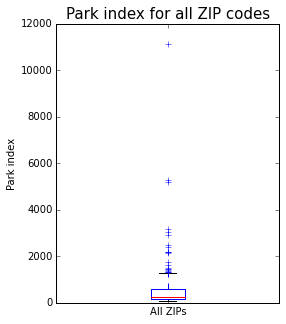

In [40]:
#Boxplotting the park index for all ZIP codes to have check its range

pl.figure(figsize=(4,5))
pl.boxplot(park_index.values())
pl.xticks([1], ['All ZIPs'])

pl.ylabel("Park index", fontsize=10)
pl.title("Park index for all ZIP codes", fontsize=15)

#4.1. a dataframe like the one derived in TASK 3 but with an additional column: the access to park for the zip codes of the 5 identified facilities.

In [41]:
#Including green_index column

facilities5['park_index'] = facilities5['zipcode'].map(park_index)

facilities5

,facility_name,facility_id,count,zipcode,highway_length,murder_index,park_index
0,Lincoln Medical & Mental Health Center,1172,1878,10451,7.914185,2991.181228,660.836860
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,10467,19.172015,1715.579510,1620.444742
2,Kings County Hospital Center,1301,1057,11203,2.212840,12501.765158,100.362024
3,Jacobi Medical Center,1165,920,10461,18.102258,1505.452743,83.554202
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,10457,5.017199,3389.742120,850.206446


#4.2 choropleth of your 'access to green spaces metric' per for all ZIP codes in NYC

In [42]:
#Including park_index column in zipcodes

zipcodes['park_index'] = zipcodes['zipcode'].map(park_index)

zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode,centroid,murder_index,park_index
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,POINT (-74.16283492076543 40.5976266699402),163.272037,5191.653307
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,POINT (-73.97966815075586 40.75916748463532),543.451159,123.077720
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,POINT (-74.01241667413252 40.71166480880465),477.997234,351.773077
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,POINT (-73.97385832649107 40.75589934710471),449.850899,112.261022
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,POINT (-73.97431480095811 40.75527331794677),462.897884,114.632400


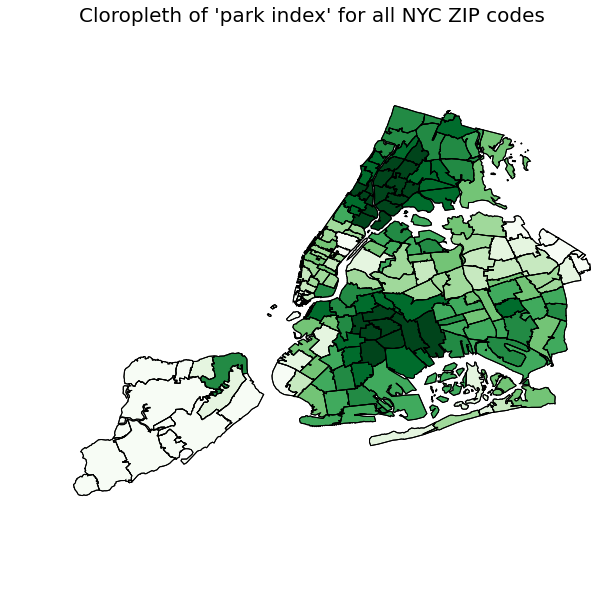

In [43]:
#Plotting cloropleth

pl.figure(figsize=(10, 10))
zipcodes.plot(column='murder_index', scheme='QUANTILES', k=9, alpha=1, colormap='Greens')
pl.axis('off')
pl.title("Cloropleth of 'park index' for all NYC ZIP codes", fontsize=20)

#TASK 5: Environmental conditions

In [44]:
#Loading 311 complaints file

complaints_data = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')
complaints_data = complaints_data.rename(columns = {'Incident Zip':'zipcode'})
print len(complaints_data)
complaints_data.head()

1611812


,Created Date,Complaint Type,zipcode
0,12/31/2013 11:59:41 AM,Street Sign - Damaged,11378
1,12/31/2013 11:59:00 AM,Water System,10040
2,12/31/2013 11:59:00 AM,Sanitation Condition,11205
3,12/31/2013 11:59:00 AM,Air Quality,10012
4,12/31/2013 11:59:00 AM,Missed Collection (All Materials),10301


In [45]:
#Separating 'valid' complaints

validcomplaints = ['UNSANITARY CONDITION','Dirty Conditions', 'Sewer',
                   'Hazardous Material','Construction',
                   'Indoor Air Quality','Indoor Sewage','Air Quality',
                   'HEATING','Industrial Waste','Mold','Asbestos',
                   'Sweeping/Missed-Inadequate','Smoking',
                   'Non-Residential Heat','Lead','Standing Water',
                    'Water Quality','Unsanitary Animal Facility',
                   'PAINT - PLASTER','GENERAL CONSTRUCTION']

val_complaints = complaints_data[complaints_data['Complaint Type'].isin(validcomplaints)]
print len(val_complaints)
val_complaints.head()

489585


,Created Date,Complaint Type,zipcode
3,12/31/2013 11:59:00 AM,Air Quality,10012
17,12/31/2013 11:55:00 AM,Sewer,10306
18,12/31/2013 11:55:00 AM,Sewer,11207
23,12/31/2013 11:53:00 AM,Dirty Conditions,10022
31,12/31/2013 11:51:00 AM,Sewer,11211


In [46]:
#Grouping both complaint databases by ZIP code and counting complaints

complaints_data = complaints_data.groupby(['zipcode']).count()
val_complaints = val_complaints.groupby(['zipcode']).count()

complaints_data = complaints_data.rename(columns = {'Created Date':'Total Complaints'})
val_complaints =val_complaints.rename(columns = {'Created Date':'Valid Complaints'})

complaints_data = complaints_data[['Total Complaints']]
val_complaints  = val_complaints[['Valid Complaints']]

In [47]:
#Merging complaints data

complaints_data['zipcode'] = complaints_data.index
val_complaints['zipcode'] = val_complaints.index

complaints_data.index = range(len(complaints_data))
val_complaints.index = range(len(val_complaints))

complaints_merged = pd.merge(complaints_data, val_complaints, on = ['zipcode'])
complaints_merged['zipcode'] = complaints_merged['zipcode'].apply(int)
complaints_merged = complaints_merged[complaints_merged['zipcode'].isin(zipcodes['zipcode'])]
complaints_merged.index = range(len(complaints_merged))
complaints_merged.head()

,Total Complaints,zipcode,Valid Complaints
0,6836,10001,912
1,11281,10002,2342
2,11281,10003,2302
3,1539,10004,105
4,1830,10005,94


In [48]:
#Calculating normalized complaints

complaints_merged['normalized_311'] = complaints_merged['Valid Complaints']/complaints_merged['Total Complaints']
complaints_merged = complaints_merged[['zipcode', 'normalized_311']]
complaints_merged.head()

,zipcode,normalized_311
0,10001,0.133411
1,10002,0.207606
2,10003,0.204060
3,10004,0.068226
4,10005,0.051366


In [49]:
#Creating dictionary for complaints

normalized_311 = {}

for i in range(len(complaints_merged)):
    normalized_311[complaints_merged['zipcode'][i]] = complaints_merged['normalized_311'][i]

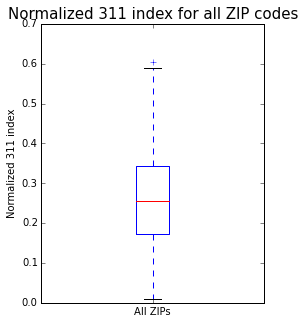

In [50]:
#Boxplotting the park index for all ZIP codes to have check its range

pl.figure(figsize=(4,5))
pl.boxplot(normalized_311.values())
pl.xticks([1], ['All ZIPs'])

pl.ylabel("Normalized 311 index", fontsize=10)
pl.title("Normalized 311 index for all ZIP codes", fontsize=15)

#5.1. a dataframe like the one derived in TASK 4 but with an additional column containing this information

In [51]:
#Including normalized_311 column

facilities5['normalized_311'] = facilities5['zipcode'].map(normalized_311)

facilities5

,facility_name,facility_id,count,zipcode,highway_length,murder_index,park_index,normalized_311
0,Lincoln Medical & Mental Health Center,1172,1878,10451,7.914185,2991.181228,660.836860,0.480029
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,10467,19.172015,1715.579510,1620.444742,0.527134
2,Kings County Hospital Center,1301,1057,11203,2.212840,12501.765158,100.362024,0.412764
3,Jacobi Medical Center,1165,920,10461,18.102258,1505.452743,83.554202,0.304519
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,10457,5.017199,3389.742120,850.206446,0.532609


#5.2. make a choropleth of the normalized 311 calls relevant to environmental conditions per for all ZIP codes in NYC


In [52]:
#Including normalized_311 column in zipcodes

zipcodes['normalized_311'] =  zipcodes['zipcode'].map(normalized_311)
                                          
zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode,centroid,murder_index,park_index,normalized_311
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,POINT (-74.16283492076543 40.5976266699402),163.272037,5191.653307,0.123781
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,POINT (-73.97966815075586 40.75916748463532),543.451159,123.077720,NaN
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,POINT (-74.01241667413252 40.71166480880465),477.997234,351.773077,NaN
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,POINT (-73.97385832649107 40.75589934710471),449.850899,112.261022,NaN
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,POINT (-73.97431480095811 40.75527331794677),462.897884,114.632400,NaN


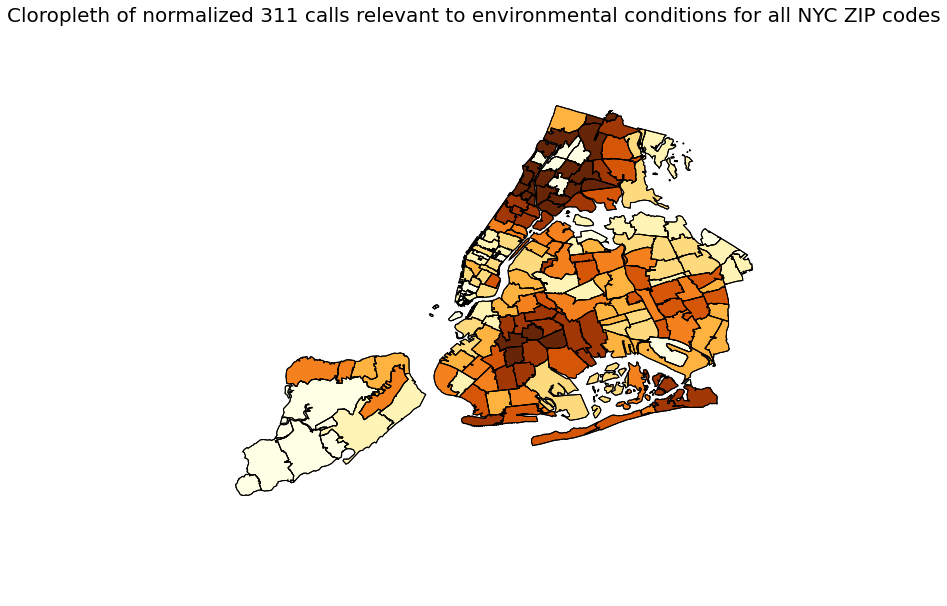

In [53]:
#Plotting cloropleth

pl.figure(figsize=(10, 10))
zipcodes.plot(column='normalized_311', scheme='QUANTILES', k=9, alpha=1, colormap='YlOrBr')
pl.axis('off')
pl.title("Cloropleth of normalized 311 calls relevant to environmental conditions for all NYC ZIP codes", fontsize=20)

#TASK 6

IMPORTANT NOTE ON HIGHWAY LENGTHS: I believe a nornalization of highway lengths would be ideal, given their implication to asthma risk depend more on their concentration than their absolute value. However, I have tested calculating a ratio (i.e. highway length per ZIP code area) and the results lacked coherence, as ZIP codes that correspond to just a block have relatively high highway lengths assigned to it. Therefore, as I don't fully understand how "highway lengths" were calculated, I'll just use the variable in its pure form.

In [54]:
#Using the logs of 'highway length', 'murder index', 'park index' and 'count' given their skewness
#http://people.stern.nyu.edu/wgreene/Statistics/MultipleRegressionBasicsCollection.pdf

regression_db = pd.DataFrame()

regression_db['x1'] = np.log(facilities5['highway_length'])
regression_db['x2'] = np.log(facilities5['murder_index'])
regression_db['x3'] = np.log(facilities5['park_index'])
regression_db['x4'] = facilities5['normalized_311']
regression_db['y'] = np.log(facilities5['count'])

model1 = smf.ols(formula = 'y ~ x1 + x2 + x3 + x4', data = regression_db, missing = 'drop').fit()
print model1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Tue, 22 Dec 2015   Prob (F-statistic):                nan
Time:                        15:25:44   Log-Likelihood:                 147.05
No. Observations:                   5   AIC:                            -284.1
Df Residuals:                       0   BIC:                            -286.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.6501        inf         -0        n

/usr/local/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


In [55]:
#The model seems to suffer from a serious multicolinearity issue
#Checking the correlation matrix: "problematic pairs" include all variables

np.corrcoef([regression_db.x1, regression_db.x2, regression_db.x3, regression_db.x4])

array([[ 1.        , -0.96302807,  0.28041455, -0.12235605],
       [-0.96302807,  1.        , -0.34956024,  0.04266699],
       [ 0.28041455, -0.34956024,  1.        ,  0.91539863],
       [-0.12235605,  0.04266699,  0.91539863,  1.        ]])

In [56]:
#I will test my model excluding all variables individually (in detriment of more sophisticated options, I know...)
#First: Model without highway length

model1 = smf.ols(formula = 'y ~ x2 + x3 +x4', data = regression_db, missing = 'drop').fit()
print model1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     128.6
Date:                Tue, 22 Dec 2015   Prob (F-statistic):             0.0647
Time:                        15:25:44   Log-Likelihood:                 13.411
No. Observations:                   5   AIC:                            -18.82
Df Residuals:                       1   BIC:                            -20.38
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.1841      0.700     -5.980      0.1

In [57]:
#Second: Model without murder_index

model2 = smf.ols(formula = 'y ~ x1 + x3 + x4', data = regression_db, missing = 'drop').fit()
print model2.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                 -0.972
Method:                 Least Squares   F-statistic:                    0.3427
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.814
Time:                        15:25:44   Log-Likelihood:                0.28370
No. Observations:                   5   AIC:                             7.433
Df Residuals:                       1   BIC:                             5.870
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.9038      3.782      2.090      0.2

In [58]:
#Third: Model without parks_index

model3 = smf.ols(formula = 'y ~ x1 + x2 + x4', data = regression_db, missing = 'drop').fit()
print model3.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                 -0.542
Method:                 Least Squares   F-statistic:                    0.5311
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.736
Time:                        15:25:44   Log-Likelihood:                0.89847
No. Observations:                   5   AIC:                             6.203
Df Residuals:                       1   BIC:                             4.641
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.8531     10.721     -0.266      0.8

In [59]:
#Fourth: Model without normalized_311

model4 = smf.ols(formula = 'y ~ x1 + x2 + x3', data = regression_db, missing = 'drop').fit()
print model4.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                 -0.306
Method:                 Least Squares   F-statistic:                    0.6880
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.686
Time:                        15:25:44   Log-Likelihood:                 1.3153
No. Observations:                   5   AIC:                             5.369
Df Residuals:                       1   BIC:                             3.807
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.2095      9.881     -0.325      0.8

COMMENTS: The exclusion of  normalized_311 proved to be more beneficial for the R-squared, F-statistic and p-values, so I am moving on with this model (model 1 apparently seems better, but it still suffers from multicollinearity).
The regression indicates that the presence of highways, murder rate, and accessibility to green areas explain the majority of the variance in asthma cases (R-squared of 67.4%). The p-values around 50% indicate that it is not possible to affirm these coefficients are not equal equal to zero at any confidence level below this threshold. Lastly, the Prob(F) indicates there is an 68.6% probability that all coefficients are equal to zero. However, these metrics should be interpreted with caution given our regression only used 5 observations.  

#TASK 7

In [60]:
#Calculating asthma index for all ZIP codes

zipcodes['highway_log'] = np.log(zipcodes['highway_length'])
zipcodes['murder_log'] = np.log(zipcodes['murder_index'])
zipcodes['park_log'] = np.log(zipcodes['park_index'])

zipcodes['asthma_index'] = model4.params[1]*zipcodes['highway_length'] + model4.params[2]*zipcodes['murder_index'] + \
model4.params[3]*zipcodes['park_index'] 
                        
zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode,centroid,murder_index,park_index,normalized_311,highway_log,murder_log,park_log,asthma_index
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,POINT (-74.16283492076543 40.5976266699402),163.272037,5191.653307,0.123781,3.156425,5.095418,8.554807,1201.386598
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,POINT (-73.97966815075586 40.75916748463532),543.451159,123.077720,NaN,-inf,6.297940,4.812816,521.038018
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,POINT (-74.01241667413252 40.71166480880465),477.997234,351.773077,NaN,0.369773,6.169605,5.862986,507.936006
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,POINT (-73.97385832649107 40.75589934710471),449.850899,112.261022,NaN,-inf,6.108916,4.720827,433.361540
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,POINT (-73.97431480095811 40.75527331794677),462.897884,114.632400,NaN,-inf,6.137506,4.741730,445.754471


In [61]:
#Normalizing asthma_index value before clustering

zip_cluster = zipcodes[np.isfinite(zipcodes['asthma_index'])]
zip_cluster['asthma_norm'] = whiten(zip_cluster['asthma_index'])
zip_cluster.head()

,cartodb_id,geometry,highway_length,zipcode,centroid,murder_index,park_index,normalized_311,highway_log,murder_log,park_log,asthma_index,asthma_norm
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,POINT (-74.16283492076543 40.5976266699402),163.272037,5191.653307,0.123781,3.156425,5.095418,8.554807,1201.386598,0.866134
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,POINT (-73.97966815075586 40.75916748463532),543.451159,123.077720,NaN,-inf,6.297940,4.812816,521.038018,0.375640
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,POINT (-74.01241667413252 40.71166480880465),477.997234,351.773077,NaN,0.369773,6.169605,5.862986,507.936006,0.366194
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,POINT (-73.97385832649107 40.75589934710471),449.850899,112.261022,NaN,-inf,6.108916,4.720827,433.361540,0.312430
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,POINT (-73.97431480095811 40.75527331794677),462.897884,114.632400,NaN,-inf,6.137506,4.741730,445.754471,0.321365


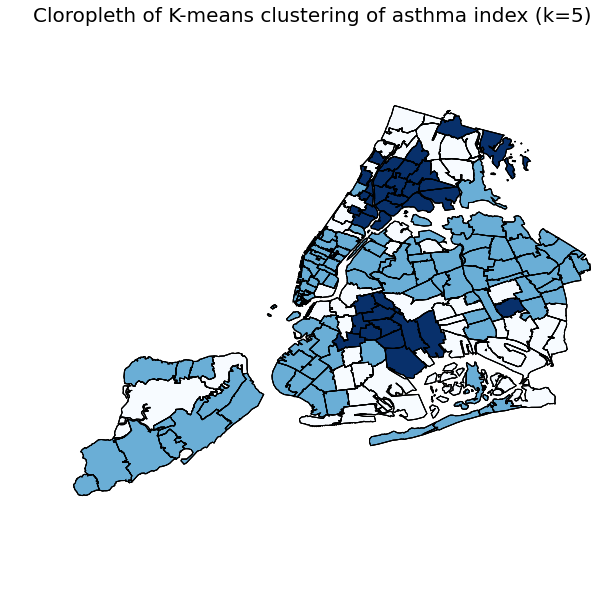

In [62]:
#Computing and plotting K-means clustering with k=5

K = zip_cluster.asthma_norm.reshape(1, len(zip_cluster)).transpose()

kmeans = KMeans(n_clusters=5, n_init=100)
kmeans.fit(K)
labels = kmeans.labels_
zip_cluster['labels'] = labels
pl.figure(figsize=(10, 10))
zip_cluster.plot(column = 'labels', scheme='QUANTILES', alpha=1, colormap='Blues')
zipcodes.plot(alpha=0)
pl.axis('off')
pl.title("Cloropleth of K-means clustering of asthma index (k=5)", fontsize=20)
pl.show()

#Discuss

The clustering of my model suggests a correlation between geographical location and asthma risk (defined by my model), as clusters tend to encompasses multiple neighboring ZIP codes. This follows the trend of the standalone cloropaths of the variables I've included in my model, namely the the murder rate, the accessibility to parks, and the sanitary conditions of each ZIP code.  These three variables were shown to impact asthma cases with a similar degree of confidence. The main weaknesses of the model, in my view, are the limited number of observations used in the regression and the fact that the population of each ZIP code wasn't taken into consideration (i.e. a higher number of asthma cases might simply stem from a higher population in this ZIP code). Besides, the correlation between the variables is most likely due to socieconomic factors, so I would most likely add a related variable to control this impact.

#EXTRA CREDIT

You can also validate your model using the discharge information form the data you downloaded earlier for other facilities.

In [63]:
#Loading full facilities' count

asthmaQuery = '''
SELECT facility_id, count(*) 
FROM nyc_discharge_2013
WHERE ccs_diagnosis_description
LIKE '%ASTHMA%'
GROUP BY facility_id
ORDER BY count DESC
'''

asthmaStream = queryCartoDB(asthmaQuery, format='CSV')
asthma_full = pd.read_csv(asthmaStream)
asthma_full.head()

,facility_id,count
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


In [64]:
#Joining full facilities' info

facilities_full = pd.merge(asthma_full, facilities, on=['facility_id'])
facilities_full = facilities_full[['facility_name', 'facility_id', 'count', 'facility_zip_code']]
facilities_full = facilities_full.rename(columns = {'facility_zip_code':'zipcode'})
facilities_full.head()

,facility_name,facility_id,count,zipcode
0,Lincoln Medical & Mental Health Center,1172,1878,10451
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,10467
2,Kings County Hospital Center,1301,1057,11203
3,Jacobi Medical Center,1165,920,10461
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,10457


In [65]:
#Joining zipcodes

facilities_full = pd.merge(facilities_full, zipcodes, on=['zipcode'], how='left')
facilities_full['count_log'] = np.log(facilities_full['count'])
#facilities_full['murder_log'] = np.log(facilities_full['murder_index'])
#facilities_full['park_log'] = np.log(facilities_full['park_index'])

facilities_full.head()

,facility_name,facility_id,count,zipcode,cartodb_id,geometry,highway_length,centroid,murder_index,park_index,normalized_311,highway_log,murder_log,park_log,asthma_index,count_log
0,Lincoln Medical & Mental Health Center,1172,1878,10451,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,POINT (-73.92373521246833 40.8210489543591),2991.181228,660.836860,0.480029,2.068657,8.003424,6.493507,2871.346176,7.537963
1,Montefiore Medical Center - Henry & Lucy Moses...,1169,1786,10467,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,POINT (-73.87204788105468 40.87792450926541),1715.579510,1620.444742,0.527134,2.953452,7.447506,7.390456,1906.225714,7.487734
2,Kings County Hospital Center,1301,1057,11203,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,POINT (-73.93439675360662 40.64941152279825),12501.765158,100.362024,0.412764,0.794277,9.433625,4.608784,11445.239558,6.963190
3,Jacobi Medical Center,1165,920,10461,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,POINT (-73.84089049528473 40.84679616111075),1505.452743,83.554202,0.304519,2.896037,7.316849,4.425496,1407.814391,6.824374
4,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,890,10457,123,"(POLYGON ((-73.897516 40.856183, -73.896533000...",5.017199,POINT (-73.89837402426468 40.84668734331924),3389.742120,850.206446,0.532609,1.612872,8.128509,6.745479,3270.670349,6.791221


In [66]:
#Separating the database into training and validation samples

asthma_val = facilities_full[6:]
asthma_val = asthma_val.drop([35, 47], 0) #column of NaNs or with count_log = 0
asthma_train = facilities_full[0:5]

model_train = smf.ols(formula = 'count_log ~ highway_log + murder_log + park_log', data = asthma_train).fit()
print model_train.summary()

                            OLS Regression Results                            
Dep. Variable:              count_log   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                 -0.306
Method:                 Least Squares   F-statistic:                    0.6880
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.686
Time:                        15:25:51   Log-Likelihood:                 1.3153
No. Observations:                   5   AIC:                             5.369
Df Residuals:                       1   BIC:                             3.807
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -3.2095      9.881     -0.325      

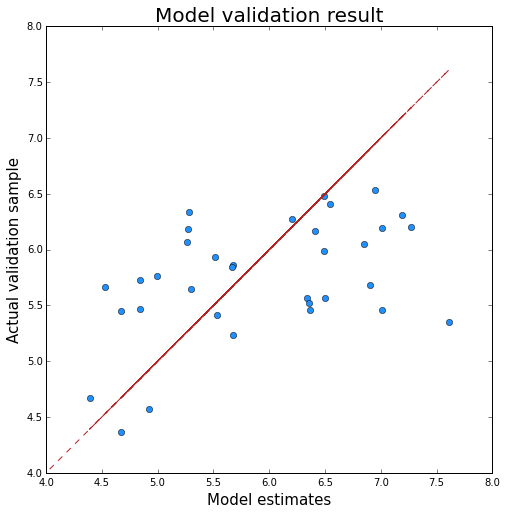

In [67]:
#Ploting the results 

model_val = model_train.predict(asthma_val)

pl.figure(figsize=(8, 8))
pl.plot(model_val, asthma_val['count_log'], 'o', color = 'dodgerblue')
pl.plot(model_val, model_val,'--', linewidth = 1, color = 'firebrick')

xlim(4, 8)
ylim(4, 8)
pl.xlabel("Model estimates", fontsize=15)
pl.ylabel("Actual validation sample", fontsize=15)
pl.title("Model validation result", fontsize=20)

As we can see above, the model seems to reasonably estimate the actual asthma risk.